# Binary search to find the smallest CNN network (with a target accuracy)

## Background
- (A) We learn binary search in AP computer science as a more efficient method to search for a number in a sorted list.
- (B) For image classification tasks we experiment with different neural network sizes to find a network that achieves a target accuracy in mind.
- This experiment combines the 2 concepts (A and B) above. The idea is to use binary search on a given network configuration (but variable number of neurons) to find the smallest number of neurons that meets a required accuracy target.
- Note that this does not solve the  generalized problem (finding the overall best CNN network). The generalized problem seems to be a much harder problem, as there are too many variables involved (hyperparameters, layer choices, etc)

## Steps
- Download a dataset (MNIST is a good choice for fast iteration, but any dataset should work)
- Create training and test data
- Sanity check on performance with a sample CNN network
- Now create a parametrized CNN network (layers are fixed, but number of neurons are variable)
- Create an iterative binary search training loop. <b> High Level</b>: Search in the range of [1, N] neurons. Start with N/2 neurons.  If accuracy is met, reduce the size, otherwise increase the size  (with binary search increments) until we find the optimal network that meets the target accuracy

## Step1: Get data and create test/train split

In [2]:
import pickle
# get the data (already locally donwnloaded)
mnist_train_test_data = pickle.load(open('data/mnist_train_test.p', 'rb'))

In [3]:
import torch
(train_x, train_y), (test_x, test_y) = mnist_train_test_data
train_x = torch.from_numpy(train_x)/255
train_y = torch.from_numpy(train_y)
test_x = torch.from_numpy(test_x)/255
test_y = torch.from_numpy(test_y)

[n, image_h, image_w] = train_x.shape
train_x = train_x.view(n, 1, image_h, image_w)

[n, image_h, image_w] = test_x.shape
test_x = test_x.view(10000, 1, image_h, image_w)

## Step2: Sanity check with a sample CNN network

### Create the network

In [10]:
from torch import nn

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        #self.flatten = nn.Flatten()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 28 * 28, 100)
        self.linear1 = nn.Linear(100, 10)
        self.rl = nn.ReLU()
        self.linear2 = nn.Linear(10, 10)

    def forward(self, x):
        #x = self.flatten(x)
        x = self.conv1(x)
        #x = x.view(x.size(0), -1)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.linear1(x)
        x = self.rl(x)
        x = self.linear2(x)
        y = self.rl(x)

        return y

model = NeuralNetwork().to('cpu')
print(model)

NeuralNetwork(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=25088, out_features=100, bias=True)
  (linear1): Linear(in_features=100, out_features=10, bias=True)
  (rl): ReLU()
  (linear2): Linear(in_features=10, out_features=10, bias=True)
)


In [11]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

def get_multi_class_acc(pred_y, label_y):
    tot_cnt = len(label_y)
    acc_cnt = 0
    for i in range(tot_cnt):
        indx = torch.argmax(pred_y[i])
        if indx == label_y[i]:
            acc_cnt += 1
    acc = float(100) * acc_cnt / tot_cnt
    #print("acc", acc)
    return acc

def get_batch(data_x, data_y):
    batch_size = 128
    ix = torch.randint(len(data_x), (batch_size,))
    x = torch.stack([data_x[i] for i in ix])
    y = torch.stack([data_y[i] for i in ix])
    #x, y = x.to(device), y.to(device)
    return x, y
    

### Train and check test performance

In [12]:
import time
model.train() #superflous, but documentation refers useful if doing dropout, etc
start_time = time.time()
desired_accuracy = 80
num_iterations = 1000
for i in range(num_iterations):
    train_x_batch, train_y_batch = get_batch(train_x, train_y)
    pred = model(train_x_batch)
    loss = loss_fn(pred, train_y_batch)
    train_acc = get_multi_class_acc(pred, train_y_batch)
    pred = model(test_x)
    test_acc = get_multi_class_acc(pred, test_y)
    if i%10 == 0:
        print(i, "train_acc", train_acc, "test_acc", test_acc)

    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if test_acc > desired_accuracy:
        print("Achieved target", i, "train_acc", train_acc, "test_acc", test_acc)
        break
end_time = time.time()
print("time taken", end_time - start_time)


0 train_acc 7.8125 test_acc 8.57
10 train_acc 23.4375 test_acc 22.14
20 train_acc 28.125 test_acc 24.15
30 train_acc 20.3125 test_acc 23.51
40 train_acc 23.4375 test_acc 22.95
50 train_acc 24.21875 test_acc 31.98
60 train_acc 29.6875 test_acc 30.64
70 train_acc 38.28125 test_acc 30.91
80 train_acc 28.125 test_acc 31.42
90 train_acc 34.375 test_acc 31.66
100 train_acc 31.25 test_acc 30.65
110 train_acc 32.8125 test_acc 29.8
120 train_acc 34.375 test_acc 30.85
130 train_acc 28.90625 test_acc 30.83
140 train_acc 30.46875 test_acc 32.06
150 train_acc 28.125 test_acc 31.42
160 train_acc 28.90625 test_acc 32.03
170 train_acc 32.8125 test_acc 35.69
180 train_acc 47.65625 test_acc 41.31
190 train_acc 46.09375 test_acc 46.32
200 train_acc 41.40625 test_acc 47.4
210 train_acc 46.875 test_acc 51.85
220 train_acc 54.6875 test_acc 55.92
230 train_acc 51.5625 test_acc 56.1
240 train_acc 57.8125 test_acc 58.66
250 train_acc 64.0625 test_acc 60.82
260 train_acc 58.59375 test_acc 59.94
270 train_acc 62

## Step3: Binary Search Experiment

### First create a parametric CNN network - with a size parameter

In [37]:
from torch import nn

class NeuralNetworkParametric(nn.Module):

    
    def __init__(self, size):
        super().__init__()
        
        conv1_out_channels = size
        conv2_out_channels = max(int(size/2),1)
        fc1_inputs = int(conv2_out_channels * image_h/4 * image_w/4) 
        fc1_outputs = int(fc1_inputs/2)
        
        self.conv1 = nn.Conv2d(1, conv1_out_channels, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.rl1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(conv1_out_channels, conv2_out_channels, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.rl2 = nn.ReLU()
        
        self.fc1 = nn.Linear(fc1_inputs, fc1_outputs)        
        self.linear1 = nn.Linear(fc1_outputs, 10)


    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.rl1(x)
        
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.rl2(x)
        
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        y = self.linear1(x)

        return y

### Helper functions (accuracy measurement and getting batch data)

In [38]:
def get_multi_class_acc(pred_y, label_y):
    tot_cnt = len(label_y)
    acc_cnt = 0
    for i in range(tot_cnt):
        indx = torch.argmax(pred_y[i])
        if indx == label_y[i]:
            acc_cnt += 1
    acc = float(100) * acc_cnt / tot_cnt
    #print("acc", acc)
    return acc


def get_batch(data_x, data_y):
    batch_size = 128
    ix = torch.randint(len(data_x), (batch_size,))
    x = torch.stack([data_x[i] for i in ix])
    y = torch.stack([data_y[i] for i in ix])
    #x, y = x.to(device), y.to(device)
    return x, y

import time

### Binary search training loop

In [39]:
def train(model, desired_test_acc):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
    model.train()
    start_time = time.time()
    num_iterations = 500
    for i in range(num_iterations):
        #print("\niteration ", i)
        train_x_batch, train_y_batch = get_batch(train_x, train_y)
        pred = model(train_x_batch)
        #print("pred shape", pred.shape, "train_y shape", train_y.shape)
        loss = loss_fn(pred, train_y_batch)
        #print("loss", loss)
        train_acc = get_multi_class_acc(pred, train_y_batch)
    
        pred = model(test_x)
        test_acc = get_multi_class_acc(pred, test_y)
        if i%10 == 0:
            print(i, "train_acc", train_acc, "test_acc", test_acc)
    
        # Backpropagation
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        if test_acc > desired_test_acc:
            print(i, "train_acc", train_acc, "test_acc", test_acc)
            print("achieved target accuracy", desired_test_acc, " breaking")
            break
            
    if test_acc > desired_test_acc:
        return 1
    return 0


def binary_search(desired_acc):
    min = 1
    max = 32

    best_size = -1
    while min <= max:
        new_test_size = (min + max) // 2  # Find the middle point
        print("===== Binary Search Loop --> Testing:", min, max, new_test_size)
        model = NeuralNetworkParametric(new_test_size).to('cpu')
        optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
        result = train(model, desired_acc)
        print("result", result)
        if result == 1:
            best_size = new_test_size
            max = new_test_size -1
        else:
            min = new_test_size + 1
            

    print("============== Final Results ==================")
    print("The smallest size parameter that works", best_size)
    model = NeuralNetworkParametric(new_test_size).to('cpu')
    print(model)
    return model
    

target_accuracy = 95
binary_search(target_accuracy)

===== Binary Search Loop --> Testing: 1 32 16
0 train_acc 10.15625 test_acc 9.76
10 train_acc 41.40625 test_acc 42.92
20 train_acc 72.65625 test_acc 71.35
30 train_acc 75.0 test_acc 73.96
40 train_acc 85.9375 test_acc 81.65
50 train_acc 81.25 test_acc 85.21
60 train_acc 91.40625 test_acc 87.28
70 train_acc 87.5 test_acc 88.58
80 train_acc 92.1875 test_acc 89.83
90 train_acc 91.40625 test_acc 90.91
100 train_acc 89.0625 test_acc 90.85
110 train_acc 90.625 test_acc 91.33
120 train_acc 92.1875 test_acc 91.52
130 train_acc 92.1875 test_acc 92.12
140 train_acc 91.40625 test_acc 92.05
150 train_acc 92.1875 test_acc 91.72
160 train_acc 90.625 test_acc 92.65
170 train_acc 90.625 test_acc 92.46
180 train_acc 92.1875 test_acc 93.69
190 train_acc 91.40625 test_acc 93.82
200 train_acc 93.75 test_acc 93.65
210 train_acc 91.40625 test_acc 93.9
220 train_acc 94.53125 test_acc 94.07
230 train_acc 95.3125 test_acc 94.24
240 train_acc 93.75 test_acc 94.44
250 train_acc 94.53125 test_acc 94.95
254 train_

NeuralNetworkParametric(
  (conv1): Conv2d(1, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (rl1): ReLU()
  (conv2): Conv2d(9, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (rl2): ReLU()
  (fc1): Linear(in_features=196, out_features=98, bias=True)
  (linear1): Linear(in_features=98, out_features=10, bias=True)
)

### Plot some of the test results

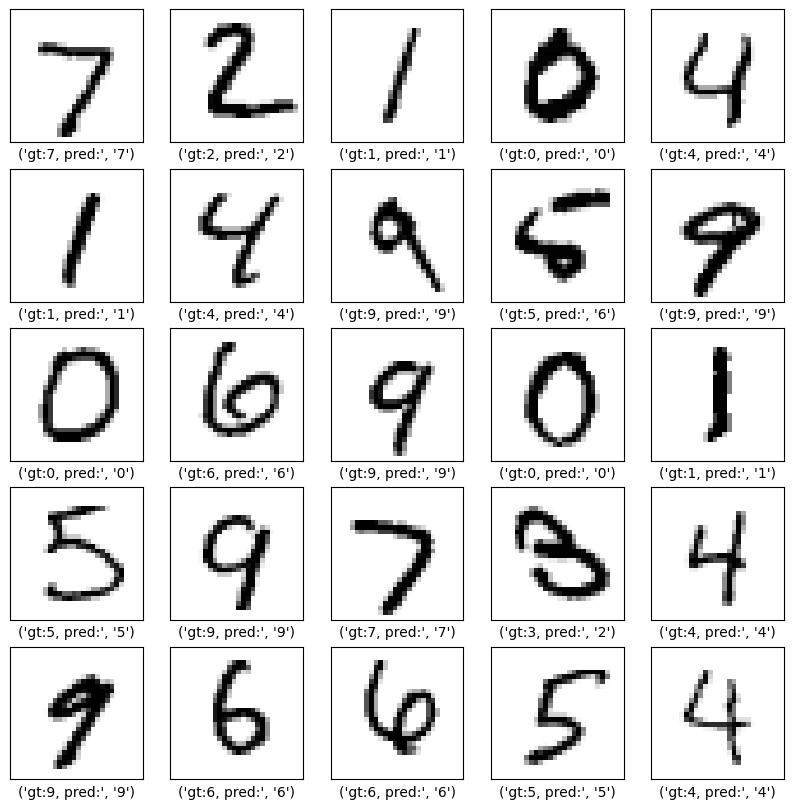

In [40]:
import matplotlib.pyplot as plt

pred = model(test_x)
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_x[i][0], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    label = "gt:" + str(test_y[i].item()) + ", pred:", str(torch.argmax(pred[i]).item())
    plt.xlabel(label)
plt.show()
